# Introduction

In this notebook we will analyze the [Census Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) from UCI Machine Learning Repository.  

The dataset contains three files: 


*   [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) - training set
*   [adult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names) - dataset description
*   [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test) - test set 


The data contains anonymous information such as age, occupation, education, working class, etc. The goal is to train a binary classifier to predict the income which has two possible values '>50K' and '<50K'. There are 48842 instances and 14 attributes in the dataset. The data contains a good blend of categorical, numerical and missing values. 

We will use **Logistic Regression** to train our model





# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from pandas.api.types import CategoricalDtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Loading Data

*   The train and test dataset doesn't come with the column names by default. Hence we assign the column names manually
*   There are ceratain instances where there are  whitespaces before and after the data values. You can pass a regex to the **sep** paramter to the pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function. We will use the separator as \* , *

*   The missing values in the dataset are indicated by **'?'**. We will use **na_values** parameter to indicate the missing values 
*   The test dataset contains some weird first row, hence we will use **skiprows=1** to skip the first row




In [2]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv('adult.data', names = columns, sep=' *, *', na_values='?',engine='python')
test_data = pd.read_csv('adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?',engine='python')

Let's look at the first 5 rows of the training data

In [3]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Similarly, we look at the first 5 rows of the test dataset

In [12]:
test_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


Both the train and the test dataset contains the predictor variable '**income**'. This needs to be removed before the data is passed to a machine-learning model

# Exploratory Data Analysis

## Cleaning the data

Let's look for any missing values in both the train and the test dataset. We need to fill/remove these values 

**Observations on the train dataset**

*  See what is the number of samples in the train data set
*  There are both categorical and numerical attributes in the dataset
*  Which columns have missing values?



In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Observations on the test dataset**

*  See what is the number of samples in the test data set
*  Is ther any columns with missing values?

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


## Handing Numerical Attributes

We will select all the numerical attributes from the dataset using [select_dtypes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html) function from the pandas dataframe library 

In [6]:
num_att = train_data.select_dtypes('int64')

The variables **age**, **hours-per-week** are self-explanatory. 


*   **fnlwgt**: sampling weight
*  ** education-num**: number of years of education in total
* **capital-gain/capital-loss**: income from investment sources other than salary/wages

fnlwgt is not related to the target variable **income** and will be removed before building the model



In [7]:
num_att.drop('fnlwgt', axis=1, inplace=True)
#test_data.drop('fnlwgt', axis=1, inplace=True)

**Data Visualizations**

Plot histograms of the numerical values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000290AF7F4048>,
      dtype=object)

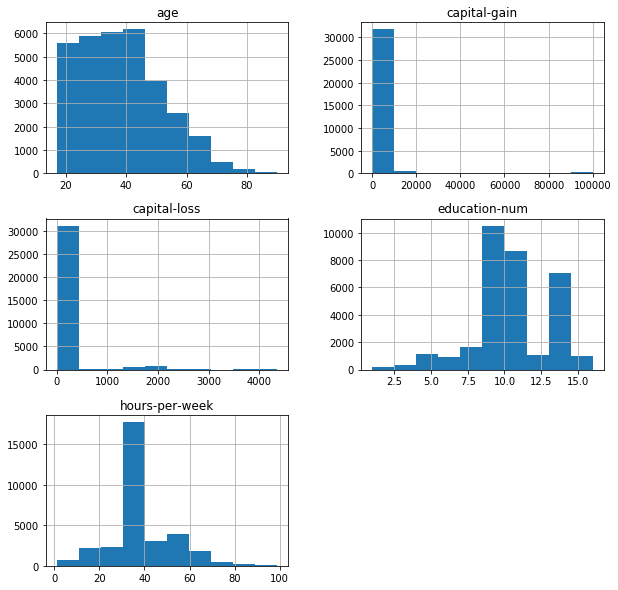

In [8]:
num_att.hist(figsize=(10, 10))

Use describe to understand the numerical attributes


In [9]:
num_att.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


**Observations**

* None of the numerical attributes have missing values 
* The values are on different scales. Many machine learning models require the features to be on the same scale. 
* We can see that there are many outliers present in the data, we will use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from sklearn library

## Handling Categorical Attributes
We will select all the categorical attributes from the dataset using [select_dtypes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html) function from the pandas dataframe library. Remember categorical variables are stored as Object type in Pandas 


In [10]:
cat_att = train_data.select_dtypes('object')

**Data-visualizations**

Visualize the workclass types with a seaborn countplot using 'income' as hue.

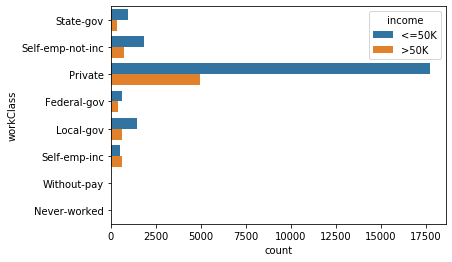

In [11]:
sns.countplot(y='workClass', hue='income', data=cat_att)

Visualize the occupation types with a seaborn countplot using 'income' as hue.

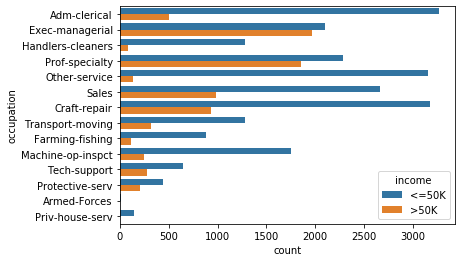

In [13]:
sns.countplot(y='occupation', hue='income', data=cat_att)

**Observations**

* All the variables are self-explanatory. 
* The column **education** is just a string representation of the column  **education-num**. We will drop the **education** column 
* The variables **workClass**, **occupation**, **native-country** have missing values. We will replace the missing values in each column with the **most_frequent** occurring value of that column.



In [14]:
cat_att.drop('education', axis=1, inplace=True)
#test_data.drop('education', axis=1, inplace=True)





We need to handle the numerical and categorical attributes differently.  Numerical attributes needs to be scaled, where as we need to fill the missing values and then encode the categorical values into numerical values.  To apply these sequence of transformations we will use the sklearn [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).  We will also build custom transformers that can be directly used with Pipeline

# Creating Pipelines

sklearn has many in-built transformers. However, if the in-built ones doesn't get the job done for you, you can build a custom transformer. All you need to do is to inherit [BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [TransformerMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) classes. You also need to implement the **fit** and **transform** methods. 
* **fit** - should return an instance of self and you can add the logic in 
* **transform** - add the logic here.

## ColumnSelector Pipeline


sklearn doesn't provide libraries to directly manipulate with pandas dataframe. We will write our own Custom Transformer which will select the corresponding attributes (either numerical or categorical)

Create a ColumnsSelector class that does this work.


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

## Numerical Data Pipeline

For the numerical data we create a numerical_pipeline. We select the numerical attributes using the **ColumnsSelector** transformer defined above and then scale the values using the Standard Scaler included in

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['age','education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'])), 
        ('scaler', StandardScaler())
        ])

In [17]:
num_pipeline.fit_transform(train_data)

array([[ 0.03067056,  1.13473876,  0.1484529 , -0.21665953, -0.03542945],
       [ 0.83710898,  1.13473876, -0.14592048, -0.21665953, -2.22215312],
       [-0.04264203, -0.42005962, -0.14592048, -0.21665953, -0.03542945],
       ...,
       [ 1.42360965, -0.42005962, -0.14592048, -0.21665953, -0.03542945],
       [-1.21564337, -0.42005962, -0.14592048, -0.21665953, -1.65522476],
       [ 0.98373415, -0.42005962,  1.88842434, -0.21665953, -0.03542945]])

## Categorical Data Pipeline

### Handling missing values

We need to replace the missing values in the categorical columns. We will replace the missing values with the most frequently occuring value in each column.  sklearn comes with [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html#) to handle missing values. However,  **Imputer** works only with numerical values. We will write a custom transformer which will accept a list of columns for which you need to replace the missing values and the strategy used to fill the missing values.

Let't buid this CategoricalImputer.


### Encoding categorical values to numerical 

All the machine learning models expects numerical values. We need to convert the categorical columns to numerical values. We will use [pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). This is similar to using [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) except that OneHotEncoder requires numerical columns. 

\\

We need to merge the train and test dataset before using pd.get_dummies as there might be classes in the test dataset that might not be present in the training dataset. But, we need to pass only the encoded train data to further transformers in the pipeline when we train the model. For this in the fit method we will concatenate the train and test dataset and find out all the possible values for a column. In the transform method, when we pass either the train dataset, we will convert each column to [Categorical](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.api.types.CategoricalDtype.html) Type and specify the list of categories that the column can take. pd.get_dummies will create an column of all zeros for the category not present in the list of categories.

\\

The transformer also takes an argument **dropFirst** which indicates whether we should drop the first column after creating dummy columns using pd.get_dummies. By default, the value is set to **True**

In [18]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [19]:
'''class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)'''
 

"class CategoricalEncoder(BaseEstimator, TransformerMixin):\n  \n  def __init__(self, dropFirst=True):\n    self.categories=dict()\n    self.dropFirst=dropFirst\n    \n  def fit(self, X, y=None):\n    join_df = pd.concat([train_data, test_data])\n    join_df = join_df.select_dtypes(include=['object'])\n    for column in join_df.columns:\n      self.categories[column] = join_df[column].value_counts().index.tolist()\n    return self\n    \n  def transform(self, X):\n    X_copy = X.copy()\n    X_copy = X_copy.select_dtypes(include=['object'])\n    for column in X_copy.columns:\n      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})\n    return pd.get_dummies(X_copy, drop_first=self.dropFirst)"

We create our pipeline for handling the categorical attributes. First transformer is to select the categorical attributed from the dataframe and then we replace the missing values and then encode the categorical features to numerical features.

In [20]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['workClass', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

### Complete Categorical Pipeline

We select the categorical attributes using the **ColumnsSelector** transformer we defined above. The missing values are replaced by the **CategoricalImputer** pipeline and finally we encode the categorical values to numerical values using the **CategoricalEncoder** transformer. 

In [21]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

## Complete Pipeline

We have two transformer pipeline i.e, **num_pipeline** and **cat_pipeline**. We can merge them using  [FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html).

In [22]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Building the Model

We now have all the pipelines for preprocessing our data, next step is to prepare the data to be passed to the model.  Let's drop 'fnlwgt' and 'education' from train_data and test_data

In [23]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

## Preparing the data for training

In [24]:
# copy the data before preprocessing
train_data_1 = train_data.copy()
test_data_1 = test_data.copy()



In [25]:
train_data_1.income.value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [26]:
# convert the income column to 0 or 1 and then drop the column for the feature vectors
# 0 if '<=50K', 1 otherwise
train_data_1["income"] = train_data_1["income"].apply(lambda x:0 if x=='<=50K' else 1)
print(train_data_1[train_data_1["income"] == 1].shape)
train_data_1.income.shape

(7841, 13)


(32561,)

In [27]:
train_data_1["income"]

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int64

In [28]:
# creating the feature vector 
y_train = train_data_1['income']

# target values
test_data_1.drop('income', axis=1, inplace=True)
X_train = train_data_1.copy() 

In [29]:
X_train.shape

(32561, 13)

## Training the model

In [30]:
# Pass the data through the full_pipeline  ¿¿(32561, 81)??
X_train = full_pipeline.fit_transform(X_train)
X_train.shape


(32561, 88)

In [31]:
train_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   education-num   32561 non-null  int64 
 3   marital-status  32561 non-null  object
 4   occupation      30718 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital-gain    32561 non-null  int64 
 9   capital-loss    32561 non-null  int64 
 10  hours-per-week  32561 non-null  int64 
 11  native-country  31978 non-null  object
 12  income          32561 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 3.2+ MB


In [32]:
type(X_train)

numpy.ndarray

In [33]:
# Create a LogisticRegression model and train it
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=0, solver='liblinear')

logreg.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
#show the coefficients of the model
logreg.coef_

array([[ 0.31300444,  0.77115926,  2.30408832,  0.2606143 ,  0.3928728 ,
         0.51776452, -0.10871255, -0.2579043 , -0.04836693,  0.17359202,
        -0.45624419, -0.22652199, -1.02372701, -0.69932966,  1.34650387,
         1.25238493, -0.74308481, -1.18036094, -0.8024785 , -0.60375532,
         0.07139264, -0.35941307,  0.16027456,  0.82987521, -0.96363377,
        -0.56457073, -0.16726523, -0.73315522, -1.64878213,  0.34570269,
         0.57434468,  0.34533998,  0.69050565, -0.01073569, -0.30185573,
         0.02816352, -0.82673146, -1.2042827 , -0.10671196,  0.9812979 ,
        -0.63207274, -0.06543043, -0.21151959, -0.47879937, -0.04229831,
        -1.1317585 , -0.29836193,  1.09951223,  0.34219727, -0.41020876,
        -1.25741726,  0.478197  , -1.02558343, -0.10329626, -0.39779795,
         0.36589056,  0.54332587,  0.49983553, -0.67302991, -0.04283792,
         0.02427776, -0.01677047, -0.23455777,  0.0825735 , -0.03816566,
        -0.11021897,  0.12254072,  0.42789381,  0.8

# Testing the model

We need to use the same pipeline for preprocessing the test data set before testing the model

In [35]:
# take a copy of the test data set
test_data_1 = test_data.copy()


In [36]:
# convert the income column to 0 or 1
print(test_data_1.income.value_counts())
# 0 if '<=50K.', 1 otherwise
test_data_1["income"] = test_data_1["income"].apply(lambda x:0 if x=='<=50K.' else 1)
print(test_data_1[test_data_1["income"] == 1].shape)
test_data_1.income.shape

<=50K.    12435
>50K.      3846
Name: income, dtype: int64
(3846, 13)


(16281,)

In [37]:
# separating the feature vecotrs and the target values
y_test = test_data_1.income
test_data_1.drop('income', axis=1, inplace=True)
X_test = test_data_1.copy()


In [38]:
# preprocess the test data using the full pipeline
X_test = full_pipeline.transform(X_test)
X_test.shape


(16281, 88)

In [39]:
# Predict the classes on the procesed data  //   [0 0 0 ... 1 0 1]
y_pred = logreg.predict(X_test)
y_pred


array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

# Model Evaluation

**We will use [accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) from sklearn to find the accuracy of the model** 

In [40]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8522203795835637


**Let's plot the [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)**

[[11585  1556]
 [  850  2290]]


Text(0.5, 257.44, 'Predicted label')

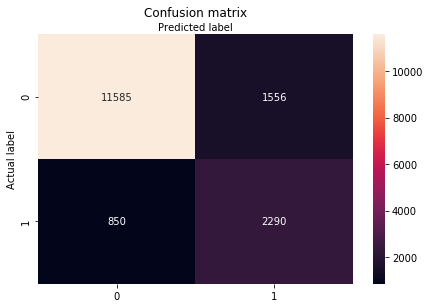

In [41]:
cnf_matrix = metrics.confusion_matrix(y_pred, y_test)
print(cnf_matrix)

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Interpretation**

* Y-axis represents the actual classes
* X-axis represents the predicted classes
* **_** times when the model correctly predicted 0 when the actual class was 0 (**True Negatives**)
* **_** times the model  predicted 0 when the actual class was 1 (**False Negatives**)
* **_** times the model  predicted 1 when the actual class was 0 (**False Positives**)
* **_** times the model correctly predicted 1 when the actual class was 1 (**True Positives**) 

# Cross Validation

We will use [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to divide our dataset into k folds. In each iteration, k-1 folds are used as training set and the remaining is used as the training set to validate the model. We use StratifiedKFold because it preserves the percentage of samples of each class. 

\\

If we use [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), we might run the risk of introducing sampling bias i.e, the train set might contain a large  number of samples where income is greater than 50K and the test set contains more samples where income is less than 50K. In this case, the model build from training data will not generalize well for test dataset. Whereas StratifiedKFold will ensure that there are enough samples of each class in both the train and test dataset.

We will use [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from the sklearn library to compute scores for each cross-validation. The parameter **cv** determines the cross-validation folds.

In [43]:
# create a cross validation model with the logistic regressor 
'''train_data_2 = train_data.copy()
test_data_2 = test_data.copy()

y_train_cross = train_data_2.income
X_train_cross = train_data_2.drop('income', axis=1)

y_test_cross = test_data_2.income
X_test_cross = test_data_2.drop('income', axis=1)'''

# find the scores from running the model using 5 folds



# Print the scores and the mean of them


In [52]:
# create a cross validation model with the logistic regressor
#join_X = pd.concat([train_data_2, test_data_2])
#join_y = pd.concat([y_train_2, y_test_2])
from sklearn import model_selection

crosval = model_selection.cross_val_predict(logreg, X_train, y_train, cv=5)

# find the scores from running the model using 5 folds

scores = model_selection.cross_val_score(logreg, X_train, y_train, cv=5)
print(scores)
print('average score: {}'.format(scores.mean()))


[0.84738216 0.84920147 0.85273342 0.85365479 0.85242629]
average score: 0.851079625855075


In [51]:
'''cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_train, y_train, cv=5)
print(scores)
print(np.mean(scores))'''

[0.8475357  0.84920147 0.85288698 0.85365479 0.85273342]
0.8512024712623514


# Fine Tuning the Model

By default Logistic Regression takes the below parameters

LogisticRegression(**C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False**)
          
We can fine-tune our model by playing around with the parameters. sklearn comes with [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to do an exhaustive search
over specified parameter values for an estimator.
          

Creating the hyperparameter space

In [0]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
random_state=[0]

# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

**Use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  to find the optimal parameters**

In [0]:
#Get the best_model

#print the penalty and c for the best model


**Predict the categories using the best model parameters**

[0 0 0 ... 1 0 1]


**Calculate the acurracy for the new model**

# Saving the model to pickle


We have done all the hard work of creating and testing the model. It would be good if we could save the model for future uses rather than retrain it. We will save our model in the [pickle](https://docs.python.org/2/library/pickle.html). 

In [0]:
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

Loading the model from pickle

In [0]:
saved_model = pickle.load(open(filename, 'rb')) 
print(saved_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Now you can predict using the saved model. 